# Introduction

In this benchmarking challenge, you will be tasked to create an [AutoRA experimentalist](https://autoresearch.github.io/autora/experimentalist/) that efficiently samples experiments in order to advance model discovery.

You can use this notebook to benchmark your experimentalist. Here, we will simulate a discovery experiment in which three different theorists are at work after each data collection cycle. You get to try out your experimentalist for two different ground truth models.

## Workflow

Your goal is to optimize the data collection process in the following workflow:

1. Sample 10 initial data points
2. Fit all theorists to those data points.

For 20 data points:
3. Pick a single novel data point using your experimentalist method. Your method may or may not take into account any of the theorists' models.
4. Add the data point to the experiment data.
5. Fit all theorists to the experiment data
6. Repeat steps 3-6 until 20 data points were collected

This workflow can be repeated two ground-truth models.








## Benchmarking Challenge Rules

- All contributing teams must publish a pip package of their experimentalist (we recommend using a pre-release) or have a working git repository that can be installed via ``!pip install git+https://github.com/musslick/autora-experimentalist-example``
- The package name must be ``autora-experimentalist-yourexperimentalist``
- The **experimentalist must have a sample function (see [this guide](https://autoresearch.github.io/autora/contribute/modules/experimentalist/))**, and it must be **compatible with the state logic** in this notebook.

- Teams will be ranked based on the final fit to a ground-truth model. Observations will be sampled across the entire domain of the ground-truth model. The rank will be accumulated across all benchmarking challenges. The team with the best accumulated rank will win a prize at the end of the workshop.
- The teams must provide a **brief presentation** (less than 5 minutes) of their experimentalist just before the final evaluation. You may use [this template for your slides](https://docs.google.com/presentation/d/1qCKqH9uXkQmGqDmROh1Jn4UcauALkMRhqlbAHubns2Q/edit?usp=sharing).

*Hint: You may take some inspiration (or come up with a combination of) the [existing experimentalists](https://autoresearch.github.io/autora/experimentalist/).*

## Grading

- Due date: **August 30**
- Submission: Through ``Stud.IP -> Tasks -> Experiment Sampling Challenge``

The grading is independent of the outcome of the benchmarking challenge.

The following points will be provided:
- A demonstration of the theorist in the ``doc/Basic Usage.ipynb``:
  -  2 points: Demonstrating how to use the experimentalist for sampling
  -  8 points: Demonstrating how the expeirmentalist compares to random sampling. This should be done by simulating closed-loop discovery process with a theorist of your choice (e.g., autora-theorist-bms) on at least two ground-truth models (*Hint: You could use the benchmarking part of the notebook below as a starting point*).
- The documentation of the experimentalist in ``doc/index.md`` must speak to the following information:
  - 2 points: the inputs: Which inputs is your experiment sampling method considering and why?
  - 2 points: sampling method: which sampling method are you using and why?
- 2 points: The code contains at least two useful unit tests for the experimentalist method (either doc tests or separate tests)
- 1 point: the contributors used issues to track bugs and work on features.
- 1 point: the contributors used (helpful) code reviews for their PRs.
- 1 point: Unit tests are automatically executed when a pull request is created.
- 1 point: The documentation is hosted automatically.

Finally, teams must outline the contributions of each team member in their submission on ``Stud.IP -> Tasks -> Experiment Sampling Challenge``.

In total, you can obtain 20 points.

## Additional Resources

- You can learn more about how to write AutoRA experimentalists in the [Contributor Guide](https://autoresearch.github.io/autora/contribute/modules/experimentalist/).

- You can learn more about how to use AutoRA in the [User Tutorial](https://autoresearch.github.io/autora/tutorials/).

- If you want to learn more about AutoRA states, you can check out [this tutorial on using AutoRA states](https://colab.research.google.com/drive/1yK1OBRpPZM1NgTMV9arHlE5j8xXjsGqq?usp=sharing).

# Code for Benchmarking your Experimentalist

## Installation

*Hint: You may want to add ``autora`` as a development dependency in your ``pyproject.tml``.*

In [18]:
%%capture
!pip install autora
!pip install autora[all-theorists]
!pip install autora[all-experimentalists]

## Imports

In [19]:
# autora state
from autora.state import State, StandardState, on_state, estimator_on_state, Delta, VariableCollection

# experiment_runner
from autora.experiment_runner.synthetic.psychology.luce_choice_ratio import luce_choice_ratio
from autora.experiment_runner.synthetic.psychology.exp_learning import exp_learning
from autora.experiment_runner.synthetic.economics.expected_value_theory import expected_value_theory
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law
from autora.experiment_runner.synthetic.psychophysics.stevens_power_law import stevens_power_law

# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample
from autora.experimentalist.falsification import falsification_sample
from autora.experimentalist.model_disagreement import model_disagreement_sample
from autora.experimentalist.uncertainty import uncertainty_sample

# theorist
from autora.theorist.bms import BMSRegressor

# sklearn
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Optional, List


## AutoRA Components & State Wrappers

First, we will need some theorists. Here, we will use three theorists simultaneously:
- the Bayesian Machine Scientist
- a polynomial theorist (from the Equation Discovery Challenge)
- a linear regression theorist.

### Polynomial Theorist

Below, we will use a polynomial theorist for our discovery simulation. We saw that it did quite well in the equation discovery challenge, so why not give it a try.

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)



## AutoRA State

Next, we define our AutoRA state which acts as modifiable "bucket" for all the data we are going to collect during the discovery cycle. Here, we will implement a more complicated AutoRA experiment in which we have simutlaneously fit 3 models (from 3 different theorists) and we want to keep track of all of them.

In [21]:
# SET UP STATE
# Here, we use a non-standard State to be able to use a multiple models
@dataclass(frozen=True)
class CustomState(State):
    variables: Optional[VariableCollection] = field(
        default=None, metadata={"delta": "replace"}
    )
    conditions: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "replace", "converter": pd.DataFrame}
    )
    experiment_data: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "extend", "converter": pd.DataFrame}
    )
    models_bms: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_lr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_polyr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    reference_conditions: Optional[pd.DataFrame] = field(
       default=None, metadata={"delta": "replace", "converter": pd.DataFrame} ## why are we using "replace" but not "extend"?
    )


## AutoRA State Wrappers

Next, we need to define a bunch of wrappers. These wrappers will make it easy to operate on the state. They specify which things are being pulled from the state and which things are being stored.

### Theorist Wrapper

In [22]:
# state wrapper for all theorists
@on_state()
def theorists_on_state(experiment_data, variables, bms_epochs):

  # extract conditions X and observations y from experiment data
  ivs = [iv.name for iv in variables.independent_variables]
  dvs = [dv.name for dv in variables.dependent_variables]
  X = experiment_data[ivs]
  y = experiment_data[dvs]

  # initialize and fit theorists
  theorist_bms = BMSRegressor(epochs=bms_epochs)
  theorist_polyr = PolynomialRegressor()
  theorist_lr = linear_model.LinearRegression()

  return Delta(models_bms = [theorist_bms.fit(X, y)],
               models_lr=[theorist_lr.fit(X, y)],
               models_polyr=[theorist_polyr.fit(X, y)])

### Experimentalist Wrappers

**To-do:**
1. Try different distance metrics: Mahalanobis, whiten(?), cosine
2. Play around with the dynamic epsilon. I feel like there is something wrong with the denominator.


In [30]:
# Latest version
# Cleaned up novelty + epsilon random sampler. Fixed the issue of always choosing random_sampler.
import numpy as np
import pandas as pd
from typing import Union

def sample(
    conditions: Union[pd.DataFrame, np.ndarray],          # already tested points
    reference_conditions: Union[pd.DataFrame, np.ndarray],# full grid
    num_samples: int = 1,
    epsilon: float = 0.3,
    random_state: int | None = None
) -> pd.DataFrame:
    """
    Grid + novelty experimentalist with scaling and greedy max–min diversity.
    Returns exactly `num_samples` rows from the full grid that have not been tested.
    """
    # 0) guards
    reference_conditions = pd.DataFrame(reference_conditions).copy()
    conditions = pd.DataFrame(conditions).copy()

    # seeded RNG for reproducibility
    rng = np.random.default_rng(random_state)

    # 1) filter out already-tested
    if conditions is None or conditions.empty:
        candidates = reference_conditions.copy()
    else:
        mask = ~reference_conditions.apply(tuple, axis=1).isin(
            conditions.apply(tuple, axis=1)
        )
        candidates = reference_conditions.loc[mask]

    if candidates.empty:
        return pd.DataFrame(columns=reference_conditions.columns).reset_index(drop=True)

    if len(candidates) <= num_samples:
        return candidates.reset_index(drop=True)

    # 2) cold start: no tested points → sample at random
    if conditions is None or conditions.empty:
        return candidates.sample(n=num_samples, random_state=random_state).reset_index(drop=True)

    # 3) scale using grid stats (Standardization)
    rc = reference_conditions.astype(float)
    rc_mean = rc.mean()
    rc_std = rc.std().replace(0, 1.0) # Avoid division by zero

    tested_scaled = (conditions.astype(float) - rc_mean) / rc_std
    cands_scaled  = (candidates.astype(float) - rc_mean) / rc_std

    tested_arr = tested_scaled.to_numpy()
    cand_arr   = cands_scaled.to_numpy()

    def min_dist_to_set(X, S): # Try Mahalanobis and whiten to check improvement
        if len(S) == 0:
            return np.full(len(X), np.inf)
        # Euclidean NN distance for each row in X to S
        return np.min(np.linalg.norm(X[:, None, :] - S[None, :, :], axis=2), axis=1)

    novelty_scores = min_dist_to_set(cand_arr, tested_arr)

    # 4) epsilon-greedy branch
    if rng.random() < epsilon:
        chosen = candidates.sample(n=num_samples, random_state=random_state)
        return chosen.reset_index(drop=True)

    # 5) greedy max–min batch for diversity (exploit)
    chosen_idx = [int(np.argmax(novelty_scores))]
    union = np.vstack([tested_arr, cand_arr[chosen_idx[0]][None, :]])
    while len(chosen_idx) < num_samples:
        d_to_union = min_dist_to_set(cand_arr, union)
        d_to_union[chosen_idx] = -np.inf  # prevent reselection
        nxt = int(np.argmax(d_to_union))
        chosen_idx.append(nxt)
        union = np.vstack([union, cand_arr[nxt][None, :]])

    chosen = candidates.iloc[chosen_idx].reset_index(drop=True)
    return chosen


In [31]:
# state wrapper for grid pooler experimentalist (generates a grid of experiment conditions)
@on_state()
def grid_pool_on_state(variables):
  return Delta(conditions=grid_pool(variables))

# state wrapper for random pooler experimentalist (generates a pool of experiment conditions)
@on_state()
def random_pool_on_state(variables, num_samples, random_state=None):
  return Delta(conditions=random_pool(variables, num_samples, random_state))

# state wrapper for random experimentalist (samples experiment conditions from a set of conditions)
@on_state()
def random_sample_on_state(conditions, all_conditions, num_samples, random_state=None):
  return Delta(conditions=random_sample(all_conditions, num_samples, random_state))

# **** STATE WRAPPER FOR YOUR EXPERIMENTALIST ***
@on_state()
def custom_sample_on_state(#experiment_data,
                           conditions,
                           reference_conditions,
                           models_bms,models_lr,models_polyr,
                           all_conditions, #not necessarily needed
                           num_samples=1,
                           step = 0,
                           max_steps = 0, ##Choose this wisely
                           random_state=None):

  # fixed epsilon works well with the improved sampler (scaling + greedy max–min)
  #epsilon = 0.3 ### Ahmet: Can play around with this too, this is fixed
  denom = max(1, max_steps)
  epsilon = max(0.05, 0.3 * (1 - step / denom))  # (kept for reference) ## This is the annealing thing I added for now

  new_conditions = sample(
      conditions=conditions,
      reference_conditions=reference_conditions,
      num_samples=num_samples,
      epsilon=epsilon,
      random_state=random_state
  )

  return Delta(conditions=new_conditions)


In [32]:
#experiment_runner = exp_learning()
experiment_runner = weber_fechner_law()
#experiment_runner = luce_choice_ratio()
#experiment_runner = expected_value_theory()
#experiment_runner = stevens_power_law

print(experiment_runner.variables)

VariableCollection(independent_variables=[IV(name='S1', value_range=(0.01, 5.0), allowed_values=array([0.01      , 0.06040404, 0.11080808, 0.16121212, 0.21161616,
       0.2620202 , 0.31242424, 0.36282828, 0.41323232, 0.46363636,
       0.5140404 , 0.56444444, 0.61484848, 0.66525253, 0.71565657,
       0.76606061, 0.81646465, 0.86686869, 0.91727273, 0.96767677,
       1.01808081, 1.06848485, 1.11888889, 1.16929293, 1.21969697,
       1.27010101, 1.32050505, 1.37090909, 1.42131313, 1.47171717,
       1.52212121, 1.57252525, 1.62292929, 1.67333333, 1.72373737,
       1.77414141, 1.82454545, 1.87494949, 1.92535354, 1.97575758,
       2.02616162, 2.07656566, 2.1269697 , 2.17737374, 2.22777778,
       2.27818182, 2.32858586, 2.3789899 , 2.42939394, 2.47979798,
       2.53020202, 2.58060606, 2.6310101 , 2.68141414, 2.73181818,
       2.78222222, 2.83262626, 2.8830303 , 2.93343434, 2.98383838,
       3.03424242, 3.08464646, 3.13505051, 3.18545455, 3.23585859,
       3.28626263, 3.33666667, 3.

### Experiment Runner Wrapper

In [33]:
# state wrapper for synthetic experiment runner
@on_state()
def run_experiment_on_state(conditions, experiment_runner):
  data = experiment_runner.run(conditions=conditions, added_noise=0.0)
  return Delta(experiment_data=data)

## Simulation Functions

First, we will need a function that we can use to evaluate the goodness of our theorists. We will use the one below (no need to parse it).

In [34]:
# the following function is used to compute the model performance
# on the validation set in terms of mean squared error
def get_validation_MSE(validation_experiment_data, working_state):
    ivs = [iv.name for iv in validation_experiment_data.variables.independent_variables]
    dvs = [dv.name for dv in validation_experiment_data.variables.dependent_variables]
    X = validation_experiment_data.experiment_data[ivs]
    y = validation_experiment_data.experiment_data[dvs]

    y_pred_bms = working_state.models_bms[-1].predict(X)
    y_pred_lr = working_state.models_lr[-1].predict(X)
    y_pred_polyr = working_state.models_polyr[-1].predict(X)

    MSE_bms = ((y - y_pred_bms)**2).mean()[0]
    MSE_lr = ((y - y_pred_lr)**2).mean()[0]
    MSE_polyr = ((y - y_pred_polyr)**2).mean()[0]

    min_MSE = min(MSE_bms, MSE_lr, MSE_polyr)

    return min_MSE

We will use the following function for benchmarking our model for any given experiment runner. Have a closer look at the script below.

It uses four different AutoRA states:
- ``validation_conditions`` and ``validation_experiment_data``: These states contains our validation sets, sampled across the entire domain of the ground truth. It is used for tracking the validation MSE of all theorists.

- ``initial_state``: This state is used to initialize the discovery process. Both the random experimentalist (operating on the ``benchmark_state``) and your custom experimentalist (operating on the ``working_state`` will use the same initial state.)

- ``benchmark_state``: This state is used for a discovery process with random sampling.

- ``working_state``: This state is used for a discovery process with your custom experimentalist.

In [35]:
def run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim=0):

  # VALIDATION STATE
  # at every step of our discovery process, we will evaluate the performance
  # of the theorist against the ground truth. Here, we will define the ground
  # truth as a grid of data points sampled across the domain of the experimental
  # design space. We will store this validation set in a separate validation states

  # create AutoRA state for validation purposes
  validation_conditions = CustomState(variables=experiment_runner.variables)
  validation_experiment_data = CustomState(variables=experiment_runner.variables)

  # our validation set will be consist of a grid of experiment conditons
  # across the entire experimental design domain
  validation_conditions = grid_pool_on_state(validation_conditions)
  validation_experiment_data = grid_pool_on_state(validation_experiment_data)
  validation_experiment_data = run_experiment_on_state(validation_experiment_data, experiment_runner=experiment_runner)


  benchmark_MSE_log = list()
  working_MSE_log = list()

  # INITIAL STATE
  # We begin our discovery experiment with randomly sampled data set for 10
  # conditions. We will use the same state for each experimentalist method.

  # create initial AutoRA state which we will use for our discovery expeirments
  initial_state = CustomState(variables=experiment_runner.variables)

  # we will initiate our discovery process with 10 randomly sampled experiment conditions
  initial_state = random_pool_on_state(initial_state,
                                      num_samples=num_initial_conditions,
                                      random_state=sim)

  # we obtain the corresponding experiment data
  initial_state = run_experiment_on_state(initial_state, experiment_runner=experiment_runner)

  # initialize benchmark state for random experimentalist
  benchmark_state = CustomState(**initial_state.__dict__)

  # initialize working state for your custom experimentalist
  working_state = CustomState(**initial_state.__dict__)

  # for each discovery cycle ##### LOOOOP #######
  for cycle in range(num_cycles):

    print("SIMULATION " + str(sim)  + " / DISCOVERY CYCLE " + str(cycle))

    # first, we fit a model to the data
    print("Fitting models on benchmark state...")
    benchmark_state = theorists_on_state(benchmark_state, bms_epochs=bms_epochs)
    print("Fitting models on working state...")
    working_state = theorists_on_state(working_state, bms_epochs=bms_epochs)

    # now we can determine how well the models do on the validation set
    benchmark_MSE = get_validation_MSE(validation_experiment_data, benchmark_state)
    benchmark_MSE_log.append(benchmark_MSE)

    working_MSE = get_validation_MSE(validation_experiment_data, working_state)
    working_MSE_log.append(working_MSE)

    # then we determine the next experiment condition
    print("Sampling new experiment conditions...")
    benchmark_state = random_sample_on_state(benchmark_state,
                                              all_conditions=validation_conditions.conditions,
                                              num_samples=num_conditions_per_cycle)

    # *** Change here: pass the full grid as reference_conditions ***
    working_state = custom_sample_on_state(working_state,
                                           reference_conditions=validation_conditions.conditions,
                                           all_conditions=validation_conditions.conditions,
                                           num_samples=num_conditions_per_cycle,
                                           step=cycle,
                                           max_steps=num_cycles)

    print("Obtaining observations...")
    # we obtain the corresponding experiment data
    benchmark_state = run_experiment_on_state(benchmark_state, experiment_runner=experiment_runner)
    working_state = run_experiment_on_state(working_state, experiment_runner=experiment_runner)

  return benchmark_MSE_log, working_MSE_log, benchmark_state, working_state




## Benchmarking Script

Let's first set some meta-parameters.

In [40]:
# meta parameters

# DO NOT CHANGE THESE PARAMETERS
num_cycles = 20
num_conditions_per_cycle = 1
num_initial_conditions = 1

# YOU MAY CHANGE THESE PARAMETERS
num_discovery_simulations = 3
bms_epochs = 1 # Note, to speed things up, you can set bms_epochs = 10 or even bms_epochs = 1 (this will lead to poor performance of the BMS regressor but the other two theorists will still fit)

### Single Run

We recommend that you probe your experimentalist function for a single run. Once you are confident that your experimentalist works, we recommend running repeating the simulation experiment for at least iterations (``num_discovery_simulations``).

How do your results look like for other ground truths, such as
- ``luce_choice_ratio()`` or
- ``expected_value_theory()`` ?

In [41]:
# setting experiment runner and theorist
#experiment_runner = exp_learning()
#experiment_runner = weber_fechner_law()
experiment_runner = luce_choice_ratio()
#experiment_runner = expected_value_theory()
#experiment_runner = stevens_power_law


# run simulation
benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner)


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:03<00:00,  3.32s/it]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


We can now plot the results for a single discovery run.

    similarity_category_A1  similarity_category_A2  similarity_category_B1  \
0                 8.585714                7.171429                5.757143   
1                 7.171429                2.928571                8.585714   
2                 7.171429                0.100000                5.757143   
3                 1.514286                8.585714                0.100000   
4                 0.100000                5.757143                8.585714   
5                 1.514286                5.757143                2.928571   
6                10.000000                8.585714                1.514286   
7                10.000000                5.757143                8.585714   
8                 7.171429                7.171429                8.585714   
9                 1.514286                2.928571               10.000000   
10                0.100000               10.000000                2.928571   
11                5.757143                2.928571              

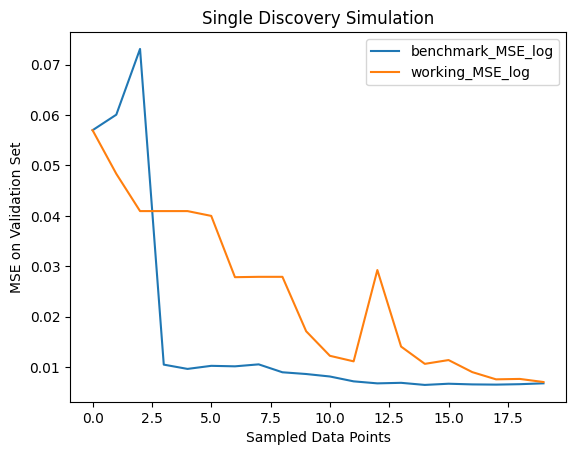

In [42]:
# lets plot the benchmark_MSE_log and the workign_MSE_log
plt.plot(benchmark_MSE_log, label='benchmark_MSE_log')
plt.plot(working_MSE_log, label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Single Discovery Simulation')
plt.legend()

# we can also investigate the final state more closely
# for example, these are all the experimental data collected
# under random sampling:
print(benchmark_state.experiment_data)
# and for your custom experimentalist
print(working_state.experiment_data)

### Averaging Across Multiple Runs

To become more confident in your experimentalist, you may want to repeat the discovery process N times...

In [43]:
benchmark_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])
working_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])

for sim in range(num_discovery_simulations):
  benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim)

  benchmark_MSE_plot_data[sim, :] = benchmark_MSE_log
  working_MSE_plot_data[sim, :] = working_MSE_log

SIMULATION 0 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 2 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


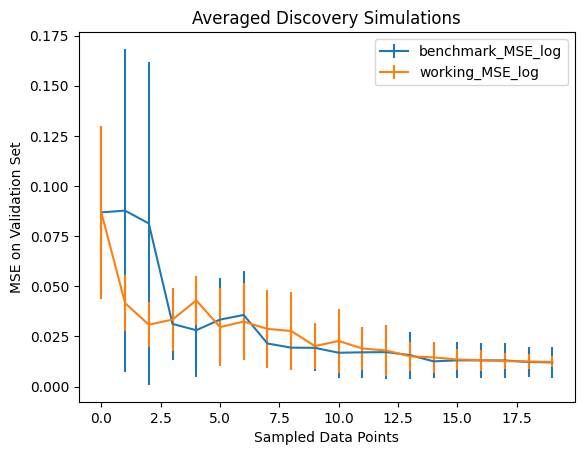

In [44]:
# plot the data with standard error
plt.errorbar(np.arange(num_cycles), np.mean(benchmark_MSE_plot_data, axis=0), yerr=np.std(benchmark_MSE_plot_data, axis=0), label='benchmark_MSE_log')
plt.errorbar(np.arange(num_cycles), np.mean(working_MSE_plot_data, axis=0), yerr=np.std(working_MSE_plot_data, axis=0), label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Averaged Discovery Simulations')
plt.legend()

## Ground Truth Model Descriptions

### Weber-Fechner-Law

The Weber-Fechner law quantifies the minimum change in a stimulus required to be noticeable. Similar to Steven's power law, the greater the intensity of a stimulus, the larger the change needed to be perceivable. This relationship is hypothesized to be proportional to the logarithm of the ratio between the two stimuli:

$\text{perceived intensity} = \log\left(\dfrac{S_1}{S_2}\right)$


where $S_1$ ($range: [0.01, 5.00]$) is the intensity of a physical stimulus (e.g., the luminosity of a lamp), $S_2$ ($range: [0.01, 5.00]$ ) is a reference stimulus (e.g., the luminosity of a background light), and $y$ is the perceived stimulus intensity (e.g. the perception of the lamp's luminosity).

### Expected Utility Model with Two Choice Options

The expected utility model evaluates decision-making under uncertainty, quantifying the expected value of different choices based on their potential outcomes and associated probabilities. The model assumes that individuals aim to maximize their expected utility when faced with two options. Each option has a specific value and probability, influenced by a certain level of noise.

For two choice options, the expected value of each option is calculated as follows:

$$
E_A = V_A \times P_A
$$

$$
E_B = V_B \times P_B
$$

where:
- $V_A$ and $V_B$ represent the values of options A and B respectively.
- $P_A$ and $P_B$ represent the probabilities associated with these options.

The probability of choosing option A $P_{\text{choose}_A}$ is then determined using the softmax function, which considers the expected values of both options and a choice temperature parameter that influences the sensitivity to differences in expected values:

$$
P_{\text{choose}_A} = \frac{\exp(E_A / \beta)}{\exp(E_A / \beta) + \exp(E_B / \beta)}
$$

In this model:
- $\beta$ controls the degree of randomness in the choice, with higher values leading to more exploration and lower values leading to more deterministic choices based on the expected values.
- The softmax function ensures that the probabilities sum to 1, providing a normalized measure of the likelihood of choosing each option.

This model captures the influence of value, probability, and noise on decision-making, reflecting the complexity and variability of human choices under uncertainty.



### Shepard-Luce Choice Rule

The Shepard-Luce choice rule, as adapted in Logan (2001),  posits that the likelihood of an individual assigning a target object, represented as $x$ , to a specific response category, represented as $i$, is proportional to their psychological similarity $\eta_i(x)$. Here, we considered a version of the model that computes the probability of assigning the target object $x_1$ to one of two response categories, given a distractor object $x_2$:

$y = p(``x_1 \text{ is perceived as category 1''}) =
 \frac{\eta_1(x_1) \cdot \alpha}{\eta_1(x_1) \cdot \alpha + \eta_2(x_1) \cdot \alpha + \eta_1(x_2) \cdot (1 - \alpha) + \eta_2(x_2) \cdot (1 - \alpha)}$

where $\alpha = 0.8$ is an attentional bias toward processing the target object $x_1$, and variables $\eta_i(x_j)$ ($range: [0.125, 10.00]$) are the psychological similarity between object $x_j$ and category $i$.